#### Goal of this script is to:
####  2| make new anova df for each participant 

In [1]:
# load packages
import numpy as np 
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime

In [2]:
NumBins = 6 # number of contrasts
NumHarms = 2 # number of harmonic data: 2F1, 4F1
NumComp = 0 # first component from RCA
NumConds = 4

nb = NumBins # makes plotting easier
pe = 0
po = 1

In [3]:
cp1 = sns.color_palette("husl", 8) # color pallete 1 
cp2 = sns.color_palette("Paired", 12)  # color pallete 2
sns.set_theme() # set global plot theme
x_lev = np.arange(0,NumBins,1) # x ticks for plotting 

In [4]:
# Main Directory of processed file from MatLab
# MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir
MainDir = 'C:\\plimon\\LTP_analysis\\RCA_F1\\CleanCRFDiff\\' # set dir
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Files on hand: {d}')
##############################################
FileN = d[-1] # choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Files on hand: ['AllClean_CRF_Diffs_20240312_1131.pkl', 'AllClean_CRF_Diffs_20240312_1328.pkl', 'AllClean_CRF_Diffs_20240313_1134.pkl', 'AllClean_CRF_Diffs_20240313_1149.pkl', 'AllClean_CRF_Diffs_20240313_1221.pkl']
Current WD: C:\plimon\LTP_analysis\RCA_F1\CleanCRFDiff\AllClean_CRF_Diffs_20240313_1221.pkl
Does File #1 Exist? True


In [5]:
def FixSaturation(NumBins,NumHarms,x):
    """
    Imports Original, Clean Contrast Response Functions 
    and fixes Supersaturation that occurs at high contrasts
    by finding the max amp if it is not at the highest contrast 
    and sets the remaining contrast responses to the max max amplitude
    dataIn = np.array, 3 dims: [subs  x  contrast responses per numharm  x   pre/post]
    """
    d = np.zeros_like((x)) # store clean data in same format
    d1,d2,d3  = x.shape # get dims for smooth iterating
    pos_rec = [] # list to save where max response was found 

    for sIn in range(d1): # acess 1 subs data 
        dataIn = x[sIn,:,:] # [12 x 2]
        for j in range(NumHarms): # access harmonic data indicies (contrast(NumBins)-dependent)
            start = (j)+((NumBins-1)*j)
            end =  ((j+1)*NumBins)
            for cond in range(NumHarms): # acaess pre and post crf's
                #print(f'[{sIn},{start}:{end},{cond}]')
                respIn = dataIn[start:end,cond] # data array 
                dataOut = np.zeros_like((respIn)) # empty to fill w fixed supersaturation
                maxpos = np.argmax(respIn) # find max pos
                pos_rec.append(maxpos)
                maxamp = respIn[maxpos] # find val of max pos
                if maxpos < NumBins: # if max pos is not at highest contrast, 
                    dataOut[:maxpos] =  respIn[:maxpos] # keep data until premature max response occurs
                    dataOut[maxpos:] = maxamp # fill remaining elements with that set max response 

                    d[sIn,start:end,cond] = dataOut # save this array in empty array
                else:
                    d[sIn,start:end,cond]  = respIn # or keep data the same if crf max response was at NumBins(highest contrast)
    return d, pos_rec

In [6]:
loadData = pkl.load(open(file_path1,'rb'))
print(loadData.keys())

diff_data = loadData['DiffData']
pp_data = loadData['PPData']
acrf = loadData['Avg']
eb = loadData['ErrorBars']
data_labels = loadData['DictMainKeys'] # condition labels for data + data_1s dict keys
contrast_levels = loadData['ContLevs'] # array for contrast labels (indexing)
contrast_labs = loadData['crfLabs'] # list for contrast labels (plotting)
note = loadData['VoiceMemo'] # personal note
print(note)

dict_keys(['DiffData', 'PPData', 'Avg', 'ErrorBars', 'VoiceMemo', 'DictMainKeys', 'ContLevs', 'crfLabs'])
['This data contains clean,processed (post-pre) contrast response function differences for each condition, max penalty - 2(3 tech)']


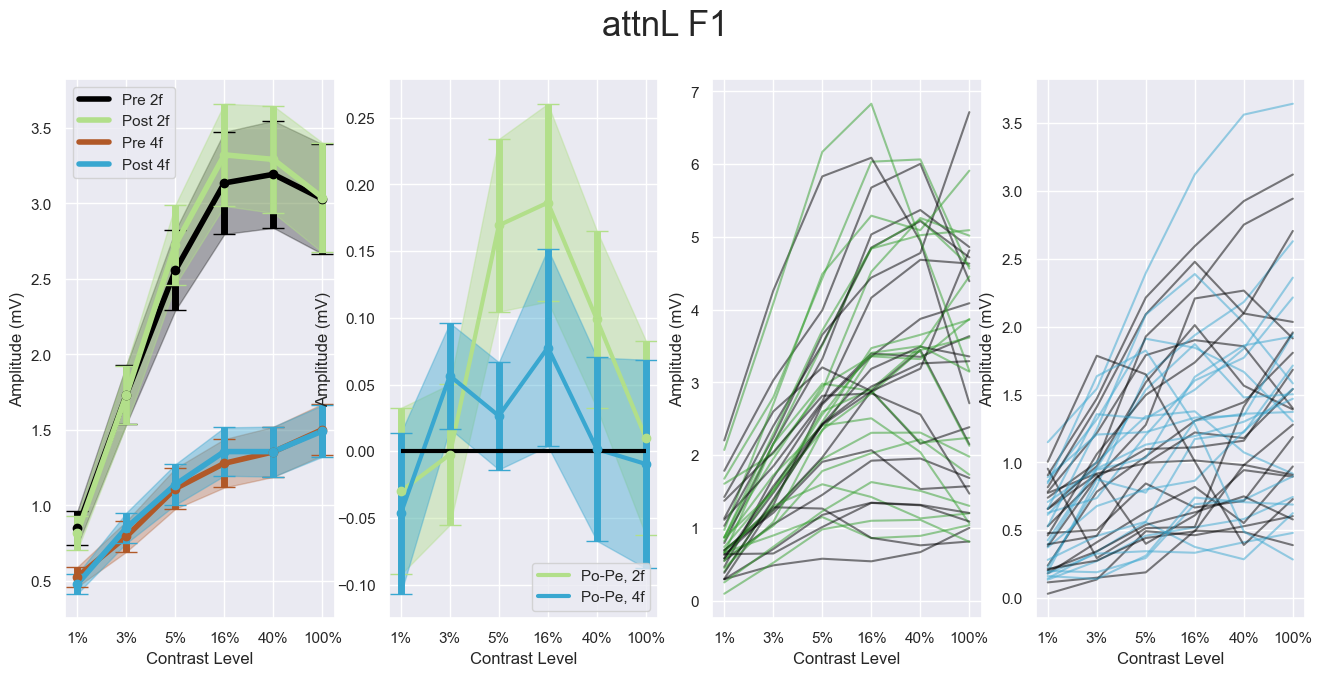

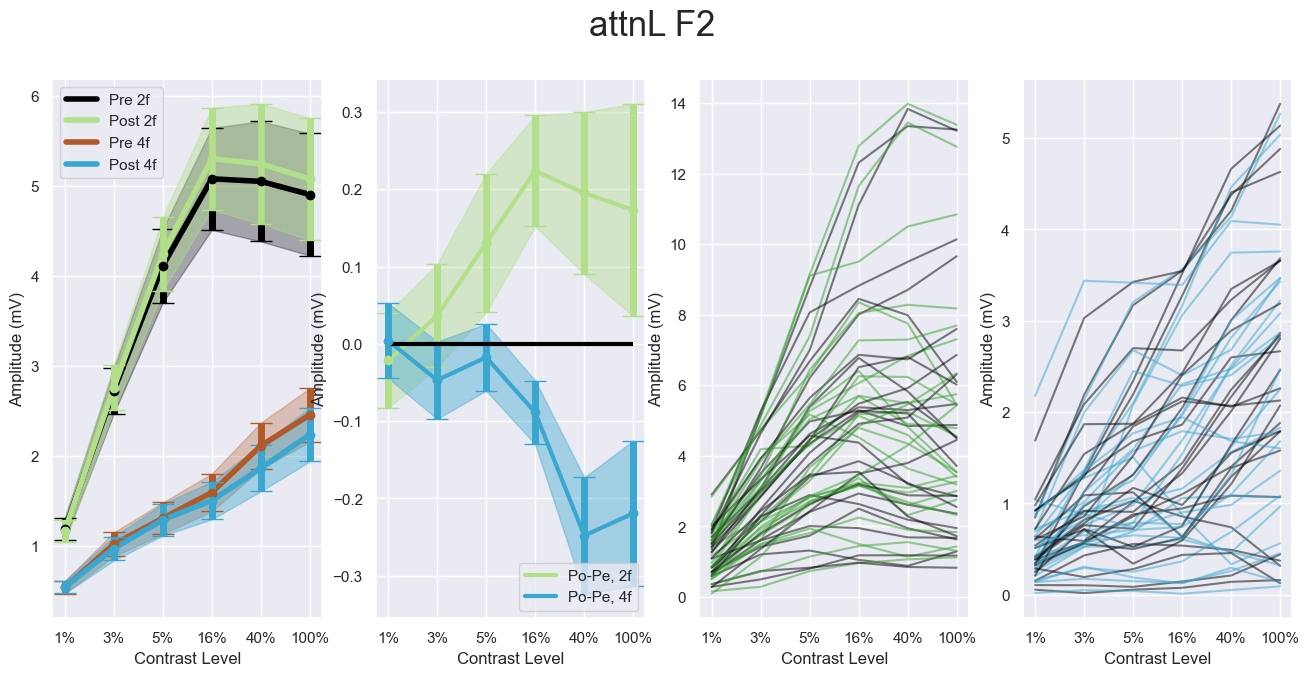

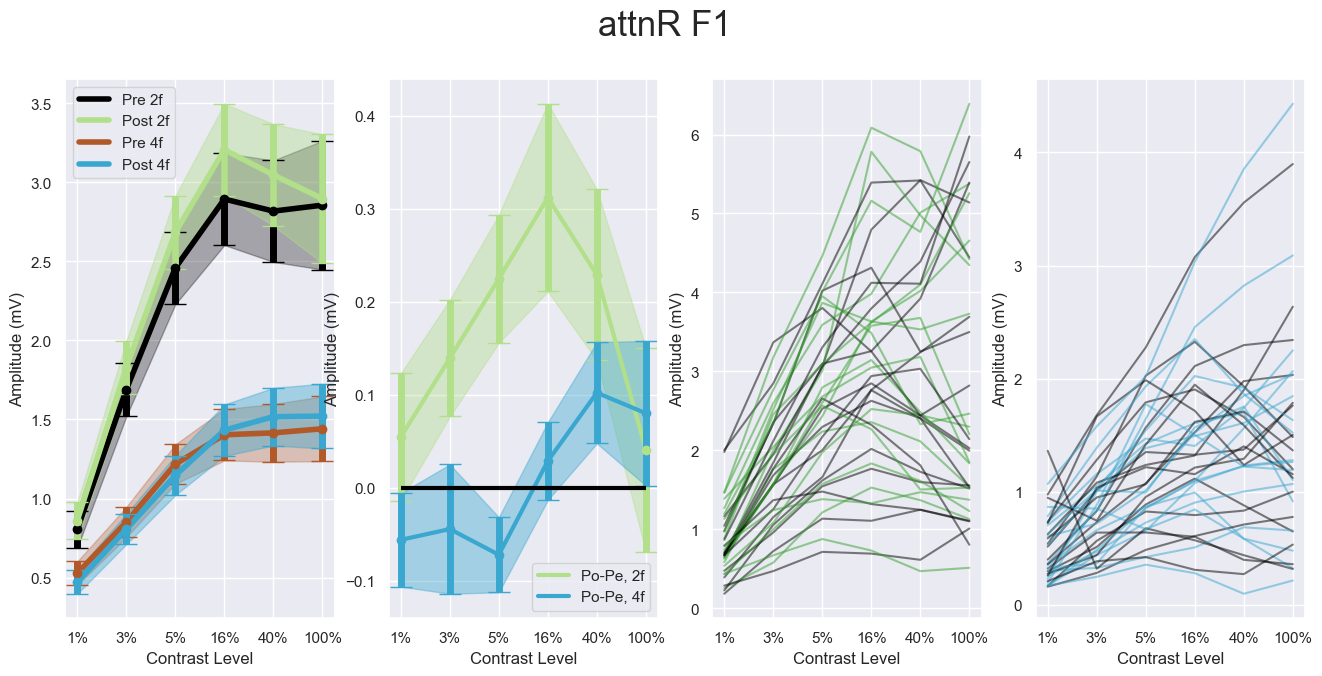

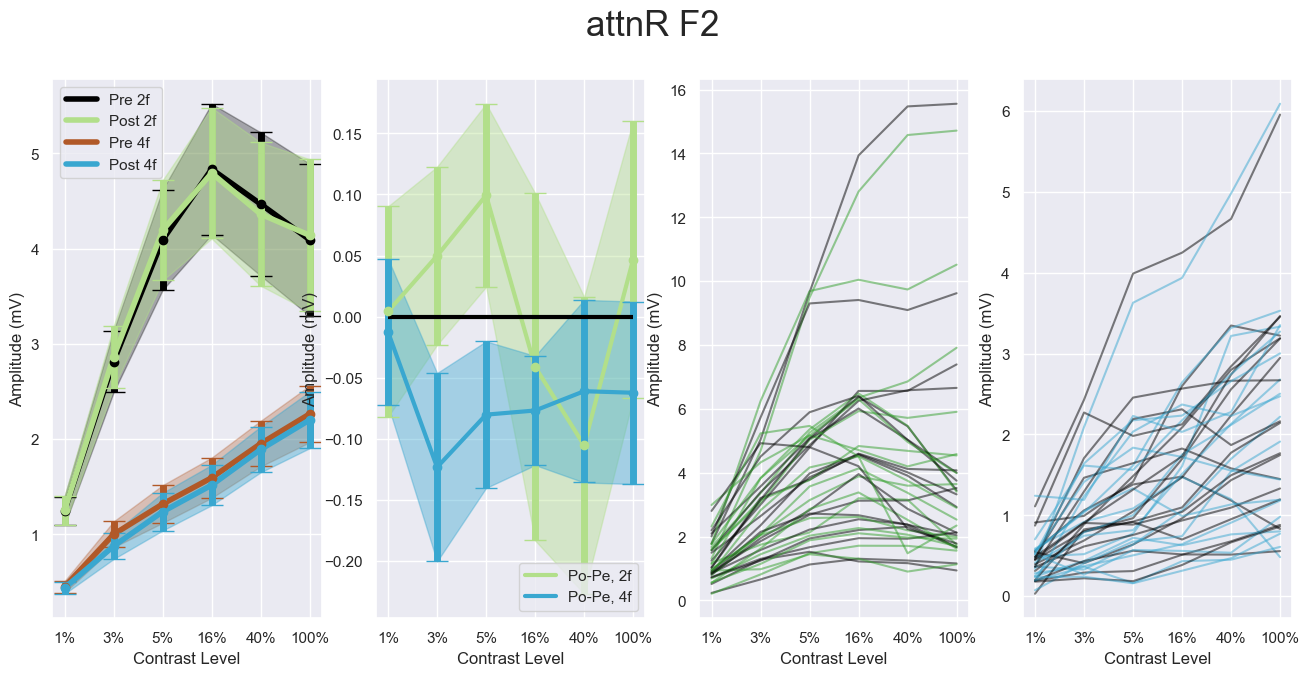

In [7]:
for co in range(NumConds):
    data = pp_data[co] # crf pre post data
    dd = diff_data[co] # post - pre data
    [ns,nc,nh] = data.shape

    m_dd = np.mean(dd,axis = 0)
    std_dd = np.std(dd, axis = 0)
    rdeb = std_dd/np.sqrt(ns) # response data error bars

    m_pre = np.mean(data[:,:,0],axis = 0,)
    m_post = np.mean(data[:,:,1],axis = 0)
    eb = np.zeros((NumHarms*NumBins,NumHarms))
    for pp in range(NumHarms):
        contrastMean = np.mean(data[:,:,pp], axis = 0)
        std = np.std(data[:,:,0],axis = 0)
        err_bar = std/np.sqrt(ns)
        eb[:,pp] = err_bar

    fig,axs = plt.subplots(1,4, figsize = (16,7), sharey = False)
    ### Fig #1 ###############################################################
    #pre 2f
    axs[0].plot(x_lev,m_pre[:nb], label = 'Pre 2f', color = 'black',linewidth = 4)
    axs[0].errorbar(x_lev,m_pre[:nb],eb[:nb,pe],fmt = 'o', color = 'black', linewidth = 3,elinewidth=5,capsize = 8 )
    axs[0].fill_between(x_lev, m_pre[:nb] - eb[:nb,pe], m_pre[:nb] + eb[:nb,pe], color='black', alpha=0.3)
    # post 2f
    axs[0].plot(x_lev,m_post[:nb], label = 'Post 2f', color = cp2[2], linewidth = 4)
    axs[0].errorbar(x_lev,m_post[:nb],eb[:nb,po],fmt = 'o', color = cp2[2], linewidth = 3,elinewidth=5,capsize = 8 )
    axs[0].fill_between(x_lev, m_post[:nb] - eb[:nb,po], m_post[:nb] + eb[:nb,po], color = cp2[2], alpha=0.4)
    # pre 4f 
    axs[0].plot(x_lev,m_pre[nb:], label = 'Pre 4f', color = cp2[11],linewidth = 4)
    axs[0].errorbar(x_lev,m_pre[nb:],eb[nb:,pe],fmt = 'o', color = cp2[11], linewidth = 3,elinewidth=5,capsize = 8 )
    axs[0].fill_between(x_lev, m_pre[nb:] - eb[nb:,pe], m_pre[nb:] + eb[nb:,pe], color=cp2[11], alpha=0.3)
    # post 4f
    axs[0].plot(x_lev,m_post[nb:], label = 'Post 4f', color = cp1[5], linewidth = 4)
    axs[0].errorbar(x_lev,m_post[nb:],eb[nb:,po],fmt = 'o', color = cp1[5], linewidth = 3,elinewidth=5,capsize = 8 )
    axs[0].fill_between(x_lev, m_post[nb:] - eb[nb:,po], m_post[nb:] + eb[nb:,po], color = cp1[5], alpha=0.4)

    axs[0].legend()
    ### Fig #2 ###############################################################

    axs[1].plot(m_dd[:nb], label = 'Po-Pe, 2f', color = cp2[2], linewidth = 3)
    axs[1].errorbar(x_lev,m_dd[:nb],rdeb[:nb],fmt = 'o', color = cp2[2], linewidth = 3,elinewidth=5,capsize = 8 )
    axs[1].fill_between(x_lev, m_dd[:nb] - rdeb[:nb], m_dd[:nb] + rdeb[:nb], color = cp2[2], alpha=0.4)

    axs[1].plot(m_dd[nb:], label = 'Po-Pe, 4f', color = cp1[5], linewidth = 3)
    axs[1].errorbar(x_lev,m_dd[nb:],rdeb[nb:],fmt = 'o', color = cp1[5], linewidth = 3,elinewidth=5,capsize = 8 )
    axs[1].fill_between(x_lev, m_dd[nb:] - rdeb[nb:], m_dd[nb:] + rdeb[nb:], color = cp1[5], alpha=0.4)

    for sIn in range(ns):
    ### Fig #3 #################################################################
        axs[2].plot(data[sIn,:6,0], color = 'black', label = 'pre', alpha = 0.5)
        axs[2].plot(data[sIn,:6,1], color = cp2[3], label = 'post', alpha = 0.5)
    ### Fig #4 #################################################################
        axs[3].plot(data[sIn,6:,0], color = 'black', label = 'pre', alpha = 0.5)
        axs[3].plot(data[sIn,6:,1], color = cp1[5], label = 'post', alpha = 0.5)

    # plot details ...
    axs[0].set_xticks(ticks = np.arange(NumBins),labels = contrast_labs)
    axs[0].set_xlabel('Contrast Level')
    axs[0].set_ylabel('Amplitude (mV)')
    axs[1].hlines(0, xmin = 0, xmax = 5, color = 'black', linewidth = 3)
    axs[1].set_xticks(ticks = np.arange(NumBins),labels = contrast_labs)
    axs[1].set_xlabel('Contrast Level')
    axs[1].set_ylabel('Amplitude (mV)')
    axs[1].legend(loc = 'lower right')
    axs[2].set_xticks(ticks = np.arange(NumBins),labels = contrast_labs)
    axs[2].set_xlabel('Contrast Level')
    axs[2].set_ylabel('Amplitude (mV)')
    axs[3].set_xticks(ticks = np.arange(NumBins),labels = contrast_labs)
    axs[3].set_xlabel('Contrast Level')
    axs[3].set_ylabel('Amplitude (mV)')
    plt.suptitle(f'{data_labels[co]}', fontsize = 25)
    #plt.tight_layout

## Fix Supersaturation and Visualize

# make data array into data frame try for post - pre and for diffs too

In [8]:
CorrectedCRF = {} # save fied supersaturation in the same format as origina crf
max_amp_rec = {} # save position where supersaturation occured

for co in range(NumConds):
    CorrectedCRF[co], max_amp_rec[co] = FixSaturation(NumBins,NumHarms,pp_data[co])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


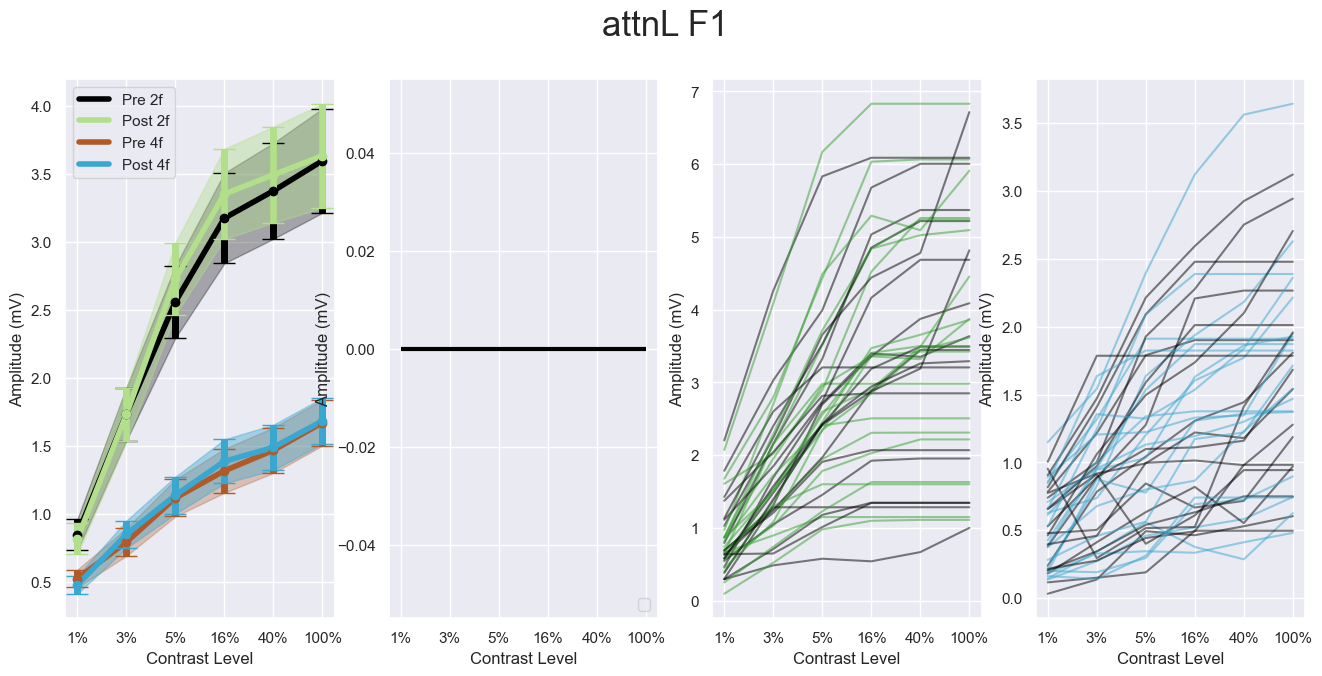

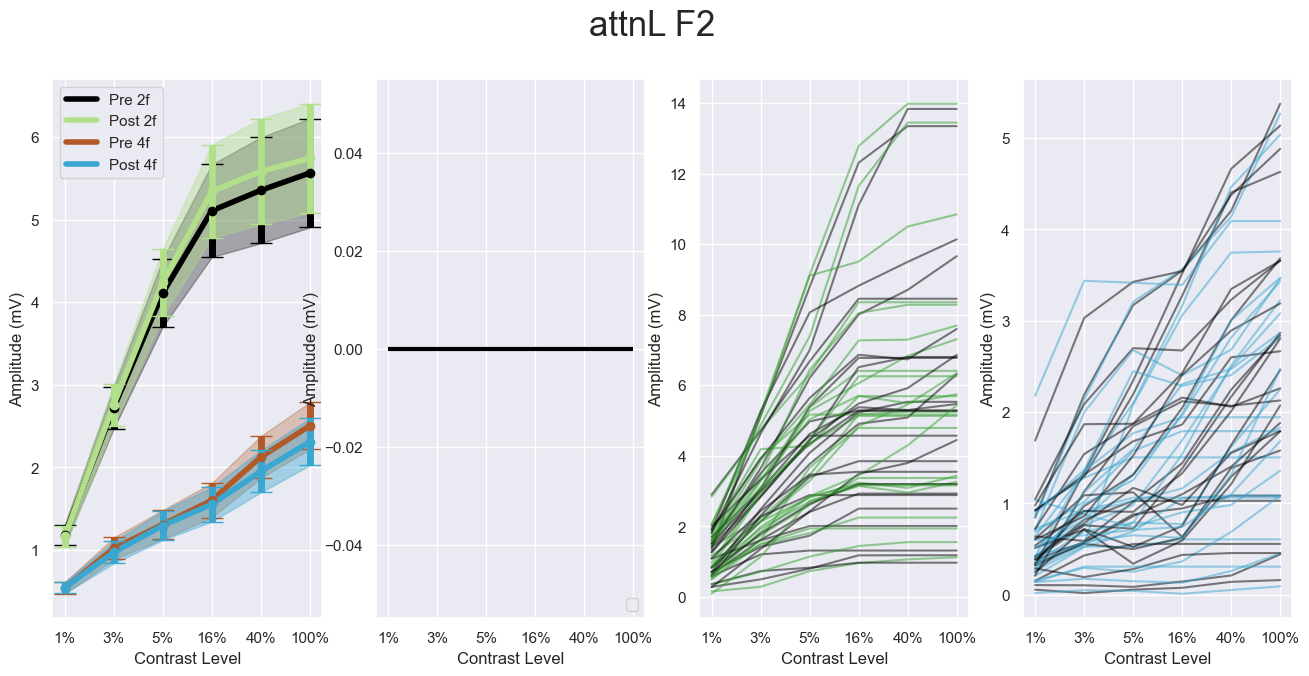

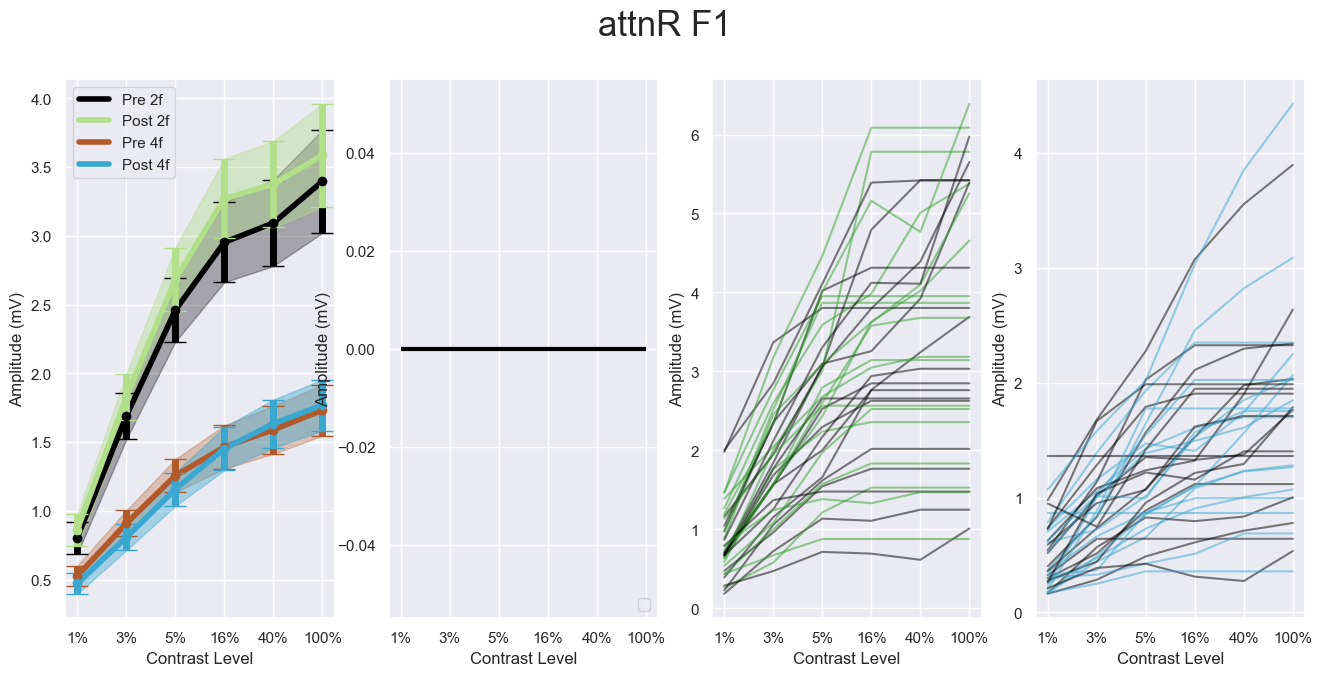

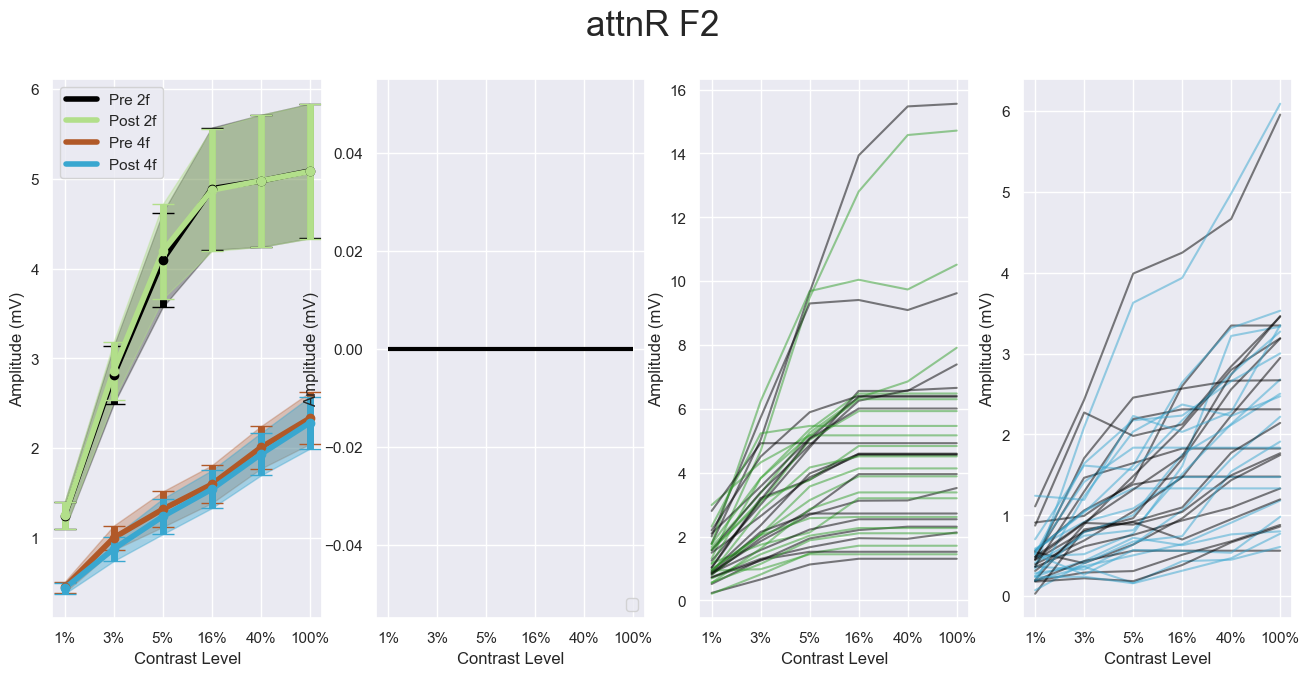

In [9]:
for co in range(NumConds):
    data = CorrectedCRF[co] # crf pre post data
    # dd = diff_data[co] # post - pre data
    [ns,nc,nh] = data.shape

    m_dd = np.mean(dd,axis = 0)
    std_dd = np.std(dd, axis = 0)
    rdeb = std_dd/np.sqrt(ns) # response data error bars

    m_pre = np.mean(data[:,:,0],axis = 0,)
    m_post = np.mean(data[:,:,1],axis = 0)
    eb = np.zeros((NumHarms*NumBins,NumHarms))
    for pp in range(NumHarms):
        contrastMean = np.mean(data[:,:,pp], axis = 0)
        std = np.std(data[:,:,0],axis = 0)
        err_bar = std/np.sqrt(ns)
        eb[:,pp] = err_bar

    fig,axs = plt.subplots(1,4, figsize = (16,7), sharey = False)
    ### Fig #1 ###############################################################
    #pre 2f
    axs[0].plot(x_lev,m_pre[:nb], label = 'Pre 2f', color = 'black',linewidth = 4)
    axs[0].errorbar(x_lev,m_pre[:nb],eb[:nb,pe],fmt = 'o', color = 'black', linewidth = 3,elinewidth=5,capsize = 8 )
    axs[0].fill_between(x_lev, m_pre[:nb] - eb[:nb,pe], m_pre[:nb] + eb[:nb,pe], color='black', alpha=0.3)
    # post 2f
    axs[0].plot(x_lev,m_post[:nb], label = 'Post 2f', color = cp2[2], linewidth = 4)
    axs[0].errorbar(x_lev,m_post[:nb],eb[:nb,po],fmt = 'o', color = cp2[2], linewidth = 3,elinewidth=5,capsize = 8 )
    axs[0].fill_between(x_lev, m_post[:nb] - eb[:nb,po], m_post[:nb] + eb[:nb,po], color = cp2[2], alpha=0.4)
    # pre 4f 
    axs[0].plot(x_lev,m_pre[nb:], label = 'Pre 4f', color = cp2[11],linewidth = 4)
    axs[0].errorbar(x_lev,m_pre[nb:],eb[nb:,pe],fmt = 'o', color = cp2[11], linewidth = 3,elinewidth=5,capsize = 8 )
    axs[0].fill_between(x_lev, m_pre[nb:] - eb[nb:,pe], m_pre[nb:] + eb[nb:,pe], color=cp2[11], alpha=0.3)
    # post 4f
    axs[0].plot(x_lev,m_post[nb:], label = 'Post 4f', color = cp1[5], linewidth = 4)
    axs[0].errorbar(x_lev,m_post[nb:],eb[nb:,po],fmt = 'o', color = cp1[5], linewidth = 3,elinewidth=5,capsize = 8 )
    axs[0].fill_between(x_lev, m_post[nb:] - eb[nb:,po], m_post[nb:] + eb[nb:,po], color = cp1[5], alpha=0.4)

    axs[0].legend()
    ### Fig #2 ###############################################################

    # axs[1].plot(m_dd[:nb], label = 'Po-Pe, 2f', color = cp2[2], linewidth = 3)
    # axs[1].errorbar(x_lev,m_dd[:nb],rdeb[:nb],fmt = 'o', color = cp2[2], linewidth = 3,elinewidth=5,capsize = 8 )
    # axs[1].fill_between(x_lev, m_dd[:nb] - rdeb[:nb], m_dd[:nb] + rdeb[:nb], color = cp2[2], alpha=0.4)

    # axs[1].plot(m_dd[nb:], label = 'Po-Pe, 4f', color = cp1[5], linewidth = 3)
    # axs[1].errorbar(x_lev,m_dd[nb:],rdeb[nb:],fmt = 'o', color = cp1[5], linewidth = 3,elinewidth=5,capsize = 8 )
    # axs[1].fill_between(x_lev, m_dd[nb:] - rdeb[nb:], m_dd[nb:] + rdeb[nb:], color = cp1[5], alpha=0.4)

    for sIn in range(ns):
    ### Fig #3 #################################################################
        axs[2].plot(data[sIn,:6,0], color = 'black', label = 'pre', alpha = 0.5)
        axs[2].plot(data[sIn,:6,1], color = cp2[3], label = 'post', alpha = 0.5)
    ### Fig #4 #################################################################
        axs[3].plot(data[sIn,6:,0], color = 'black', label = 'pre', alpha = 0.5)
        axs[3].plot(data[sIn,6:,1], color = cp1[5], label = 'post', alpha = 0.5)

    # plot details ...
    axs[0].set_xticks(ticks = np.arange(NumBins),labels = contrast_labs)
    axs[0].set_xlabel('Contrast Level')
    axs[0].set_ylabel('Amplitude (mV)')
    axs[1].hlines(0, xmin = 0, xmax = 5, color = 'black', linewidth = 3)
    axs[1].set_xticks(ticks = np.arange(NumBins),labels = contrast_labs)
    axs[1].set_xlabel('Contrast Level')
    axs[1].set_ylabel('Amplitude (mV)')
    axs[1].legend(loc = 'lower right')
    axs[2].set_xticks(ticks = np.arange(NumBins),labels = contrast_labs)
    axs[2].set_xlabel('Contrast Level')
    axs[2].set_ylabel('Amplitude (mV)')
    axs[3].set_xticks(ticks = np.arange(NumBins),labels = contrast_labs)
    axs[3].set_xlabel('Contrast Level')
    axs[3].set_ylabel('Amplitude (mV)')
    plt.suptitle(f'{data_labels[co]}', fontsize = 25)
    #plt.tight_layout

#### Export original crf and fized saturation crf

In [10]:
dictOut = {}

dictOut['crf'] = pp_data # original CRF data
dictOut['resp_diffs'] = diff_data # post - pre data for all conditions

dictOut['mod_crf'] = CorrectedCRF # crf with no supersaturation

dictOut['ConditionLabels'] = data_labels
dictOut['ContLevs'] = contrast_levels # for plotting x
dictOut['ContLabs'] = contrast_labs # for setting x ticks

In [11]:
# set save data dir 
# Set directory to save NR Data in ..new folder
# SaveDataDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir where files (.pkl, .csv) will be saved
SaveDataDir = 'C:\\plimon\\LTP_analysis\\RCA_F1\\AvgCRFs\\' # set dir where files (.pkl, .csv) will be saved
FileOutName = 'Clean_LTPData' # make sure this file changes each time you save
######################################################
dnt = datetime.now() # add date and time bc im wreckless when saving ..
fdnt = dnt.strftime("%Y%m%d_%H%M") # set the above as a string ...
FileN = f'{FileOutName}_{fdnt}.pkl' 
MatLabFileN = f'{FileOutName}_{fdnt}.mat'

NewFileNPath = os.path.join(SaveDataDir,FileN)

print('Full New File Dir: ', NewFileNPath)

if not os.path.exists(SaveDataDir):
    os.makedirs(SaveDataDir)
print('Path to Save File is:',SaveDataDir)

Full New File Dir:  C:\plimon\LTP_analysis\RCA_F1\AvgCRFs\Clean_LTPData_20240313_1457.pkl
Path to Save File is: C:\plimon\LTP_analysis\RCA_F1\AvgCRFs\


In [12]:
saveFile = 'y'

if saveFile == 'y':
 
 with open(NewFileNPath, 'wb') as file:
    pkl.dump(dictOut, file, protocol=pkl.HIGHEST_PROTOCOL)
    # save as .mat file or .csv file to import into matlab 
    
    print('Average CRF Differences Saved! :))')
else:
    print('Did Not Save File! Change file name before switching to y!')

Average CRF Differences Saved! :))
